Files already downloaded and verified
Starting WGAN Training...
Epoch [1/50] | Loss Critic: -1.5569, Loss Generator: 0.7475, FID: 277.7655
Epoch [2/50] | Loss Critic: -1.5421, Loss Generator: 0.7371, FID: 309.8595
Epoch [3/50] | Loss Critic: -1.5145, Loss Generator: 0.7182, FID: 302.5474
Epoch [4/50] | Loss Critic: -1.1080, Loss Generator: 0.6466, FID: 359.0619
Epoch [5/50] | Loss Critic: -1.1835, Loss Generator: 0.5774, FID: 258.1833
Epoch [6/50] | Loss Critic: -1.0588, Loss Generator: 0.5863, FID: 276.0858
Epoch [7/50] | Loss Critic: -0.8050, Loss Generator: 0.6048, FID: 231.0952
Epoch [8/50] | Loss Critic: -1.0479, Loss Generator: 0.5677, FID: 209.4664
Epoch [9/50] | Loss Critic: -0.9486, Loss Generator: 0.5696, FID: 222.4899
Epoch [10/50] | Loss Critic: -1.0918, Loss Generator: 0.5649, FID: 229.6001
Epoch [11/50] | Loss Critic: -1.0277, Loss Generator: 0.4187, FID: 243.5817
Epoch [12/50] | Loss Critic: -1.0934, Loss Generator: 0.4707, FID: 226.7976
Epoch [13/50] | Loss Critic: -1.3

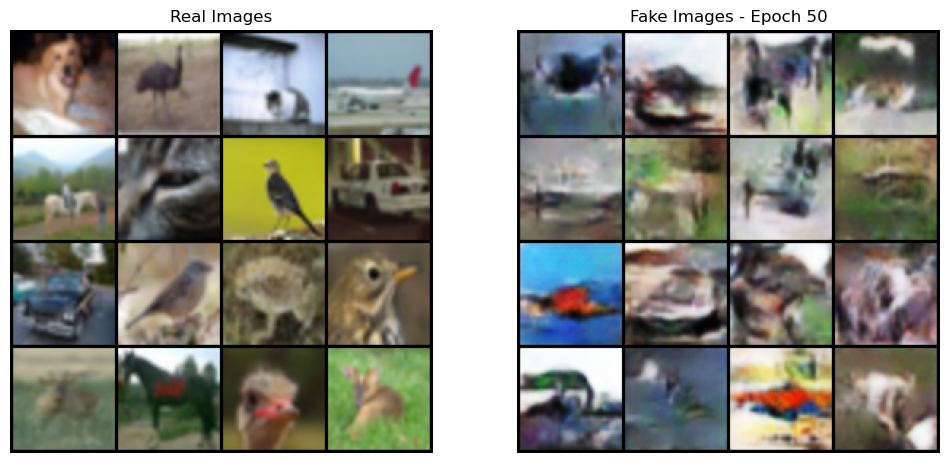

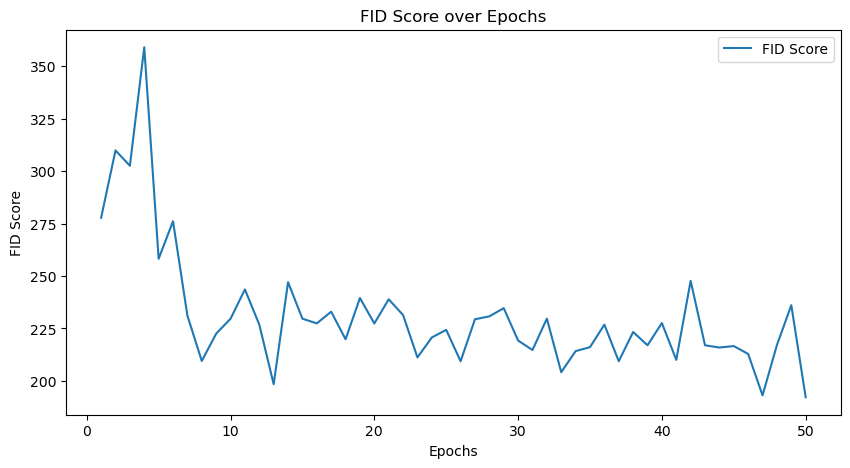

In [10]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from torchvision.models import inception_v3
from torchvision.transforms.functional import resize
import numpy as np
from scipy import linalg


transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_path = "./cifar10_data"
dataset = torchvision.datasets.CIFAR10(root=data_path, train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)


class Generator(nn.Module):
    def __init__(self, noise_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(noise_dim, features_g * 16, 4, 1, 0), 
            self._block(features_g * 16, features_g * 8, 4, 2, 1), 
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),  
            nn.Tanh() 
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),  
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0) 
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)


noise_dim = 100
channels_img = 3
features_g = 64
features_d = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Generator(noise_dim, channels_img, features_g).to(device)
critic = Critic(channels_img, features_d).to(device)

gen.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)) else None)
critic.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)) else None)

optimizer_g = optim.RMSprop(gen.parameters(), lr=5e-5)
optimizer_c = optim.RMSprop(critic.parameters(), lr=5e-5)


num_epochs = 50
fixed_noise = torch.randn(64, noise_dim, 1, 1).to(device)
fid_scores = []
inception_model = inception_v3(pretrained=True, transform_input=False).eval().to(device)
inception_model.fc = nn.Identity()

clip_value = 0.01
critic_iters = 5


def calculate_fid(real_images, fake_images, inception_model, batch_size=64):
    def preprocess_images(images):
        images = (images + 1) / 2  
        images = resize(images, [299, 299]) 
        return images

    def get_activations(images, model):
        activations = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            batch = preprocess_images(batch)
            with torch.no_grad():
                act = model(batch)
            activations.append(act.view(batch.size(0), -1).cpu().numpy())
        return np.concatenate(activations, axis=0)

    real_activations = get_activations(real_images, inception_model)
    fake_activations = get_activations(fake_images, inception_model)

    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_activations, axis=0), np.cov(fake_activations, rowvar=False)

    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return np.sum(diff ** 2) + np.trace(sigma_real + sigma_fake - 2 * covmean)


print("Starting WGAN Training...")
for epoch in range(1, num_epochs + 1):
    for real_images, _ in data_loader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        for _ in range(critic_iters):
            noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
            fake_images = gen(noise)

            loss_c = -(torch.mean(critic(real_images)) - torch.mean(critic(fake_images.detach())))
            optimizer_c.zero_grad()
            loss_c.backward()
            optimizer_c.step()

           
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

       
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake_images = gen(noise)
        loss_g = -torch.mean(critic(fake_images))
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

 
    gen.eval()
    with torch.no_grad():
        fake_images_sample = gen(fixed_noise).detach()
    fid_score = calculate_fid(real_images[:64], fake_images_sample, inception_model)
    fid_scores.append(fid_score)
    gen.train()

    print(f"Epoch [{epoch}/{num_epochs}] | Loss Critic: {loss_c:.4f}, Loss Generator: {loss_g:.4f}, FID: {fid_score:.4f}")

  
    if epoch == num_epochs:
        with torch.no_grad():
            fake_images_sample = gen(fixed_noise).detach().cpu()
        real_images_sample = real_images[:16].detach().cpu()

        real_grid = torchvision.utils.make_grid(real_images_sample, normalize=True, nrow=4)
        fake_grid = torchvision.utils.make_grid(fake_images_sample[:16], normalize=True, nrow=4)

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(real_grid.permute(1, 2, 0))
        plt.title("Real Images")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(fake_grid.permute(1, 2, 0))
        plt.title(f"Fake Images - Epoch {epoch}")
        plt.axis("off")
        plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(fid_scores) + 1), fid_scores, label="FID Score")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.title("FID Score over Epochs")
plt.legend()
plt.show()

In [12]:
fid_filename = "./npy_files/wgan_fid_scores.npy"
def save_fid_values(fid_values, filename="./fid_scores.npy"):
    np.save(filename, np.array(fid_values))
    print(f"FID values saved to {filename}.")
save_fid_values(fid_scores, fid_filename)

FID values saved to ./npy_files/wgan_fid_scores.npy.
